In [ ]:
# The following code is part of the group work for Data analystics in Energy systems and IoT

In [129]:
# Packages
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
import math
from statsmodels.tsa.arima.model import ARIMA

from matplotlib import pyplot
%matplotlib inline

from pandas.plotting import lag_plot, autocorrelation_plot

## Importing data

In [7]:
worldenergy_data = pd.read_csv("https://raw.githubusercontent.com/owid/energy-data/master/owid-energy-data.csv")
worldenergy_data
# explenation of the variables:
# https://docs.google.com/spreadsheets/d/1cqZe1LMpXbzbxCcq2ENFvcKyznkiAd9PTL05gGIKNiU/edit#gid=0

# select the specific EU countries
EU_countrylist = ["BEL", "BGR", "DNK", "DEU", "EST", "FIN", "FRA", "GRC", "IRL", "ITA", "HRV",
                  "LVA", "LTU", "LUX", "MLT", "NLD", "AUT", "POL", "PRT", "ROU", "SWE",
                  "SVK", "SVN", "ESP", "CZE", "HUN", "CYP"]
df_EU = worldenergy_data[worldenergy_data.iso_code.isin(EU_countrylist)]

# select consupmtion and production columns

columns = ["iso_code", "country", "year", "population", "gdp", "electricity_generation", "per_capita_electricity", "primary_energy_consumption", "renewables_electricity", "renewables_share_elec", "renewables_share_energy", "renewables_consumption", "renewables_elec_per_capita", "renewables_energy_per_capita", "other_renewables_share_elec", "other_renewables_share_energy", "other_renewable_consumption", "other_renewables_elec_per_capita", "other_renewables_energy_per_capita"]
df_EU_short = df_EU[columns]
df_EU_short = df_EU_short[df_EU_short.year >= 1970]
df_EU_short.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1287 entries, 1109 to 14909
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   iso_code                            1287 non-null   object 
 1   country                             1287 non-null   object 
 2   year                                1287 non-null   int64  
 3   population                          1260 non-null   float64
 4   gdp                                 1164 non-null   float64
 5   electricity_generation              947 non-null    float64
 6   per_capita_electricity              947 non-null    float64
 7   primary_energy_consumption          1252 non-null   float64
 8   renewables_electricity              947 non-null    float64
 9   renewables_share_elec               947 non-null    float64
 10  renewables_share_energy             1215 non-null   float64
 11  renewables_consumption              121

## Inital plots

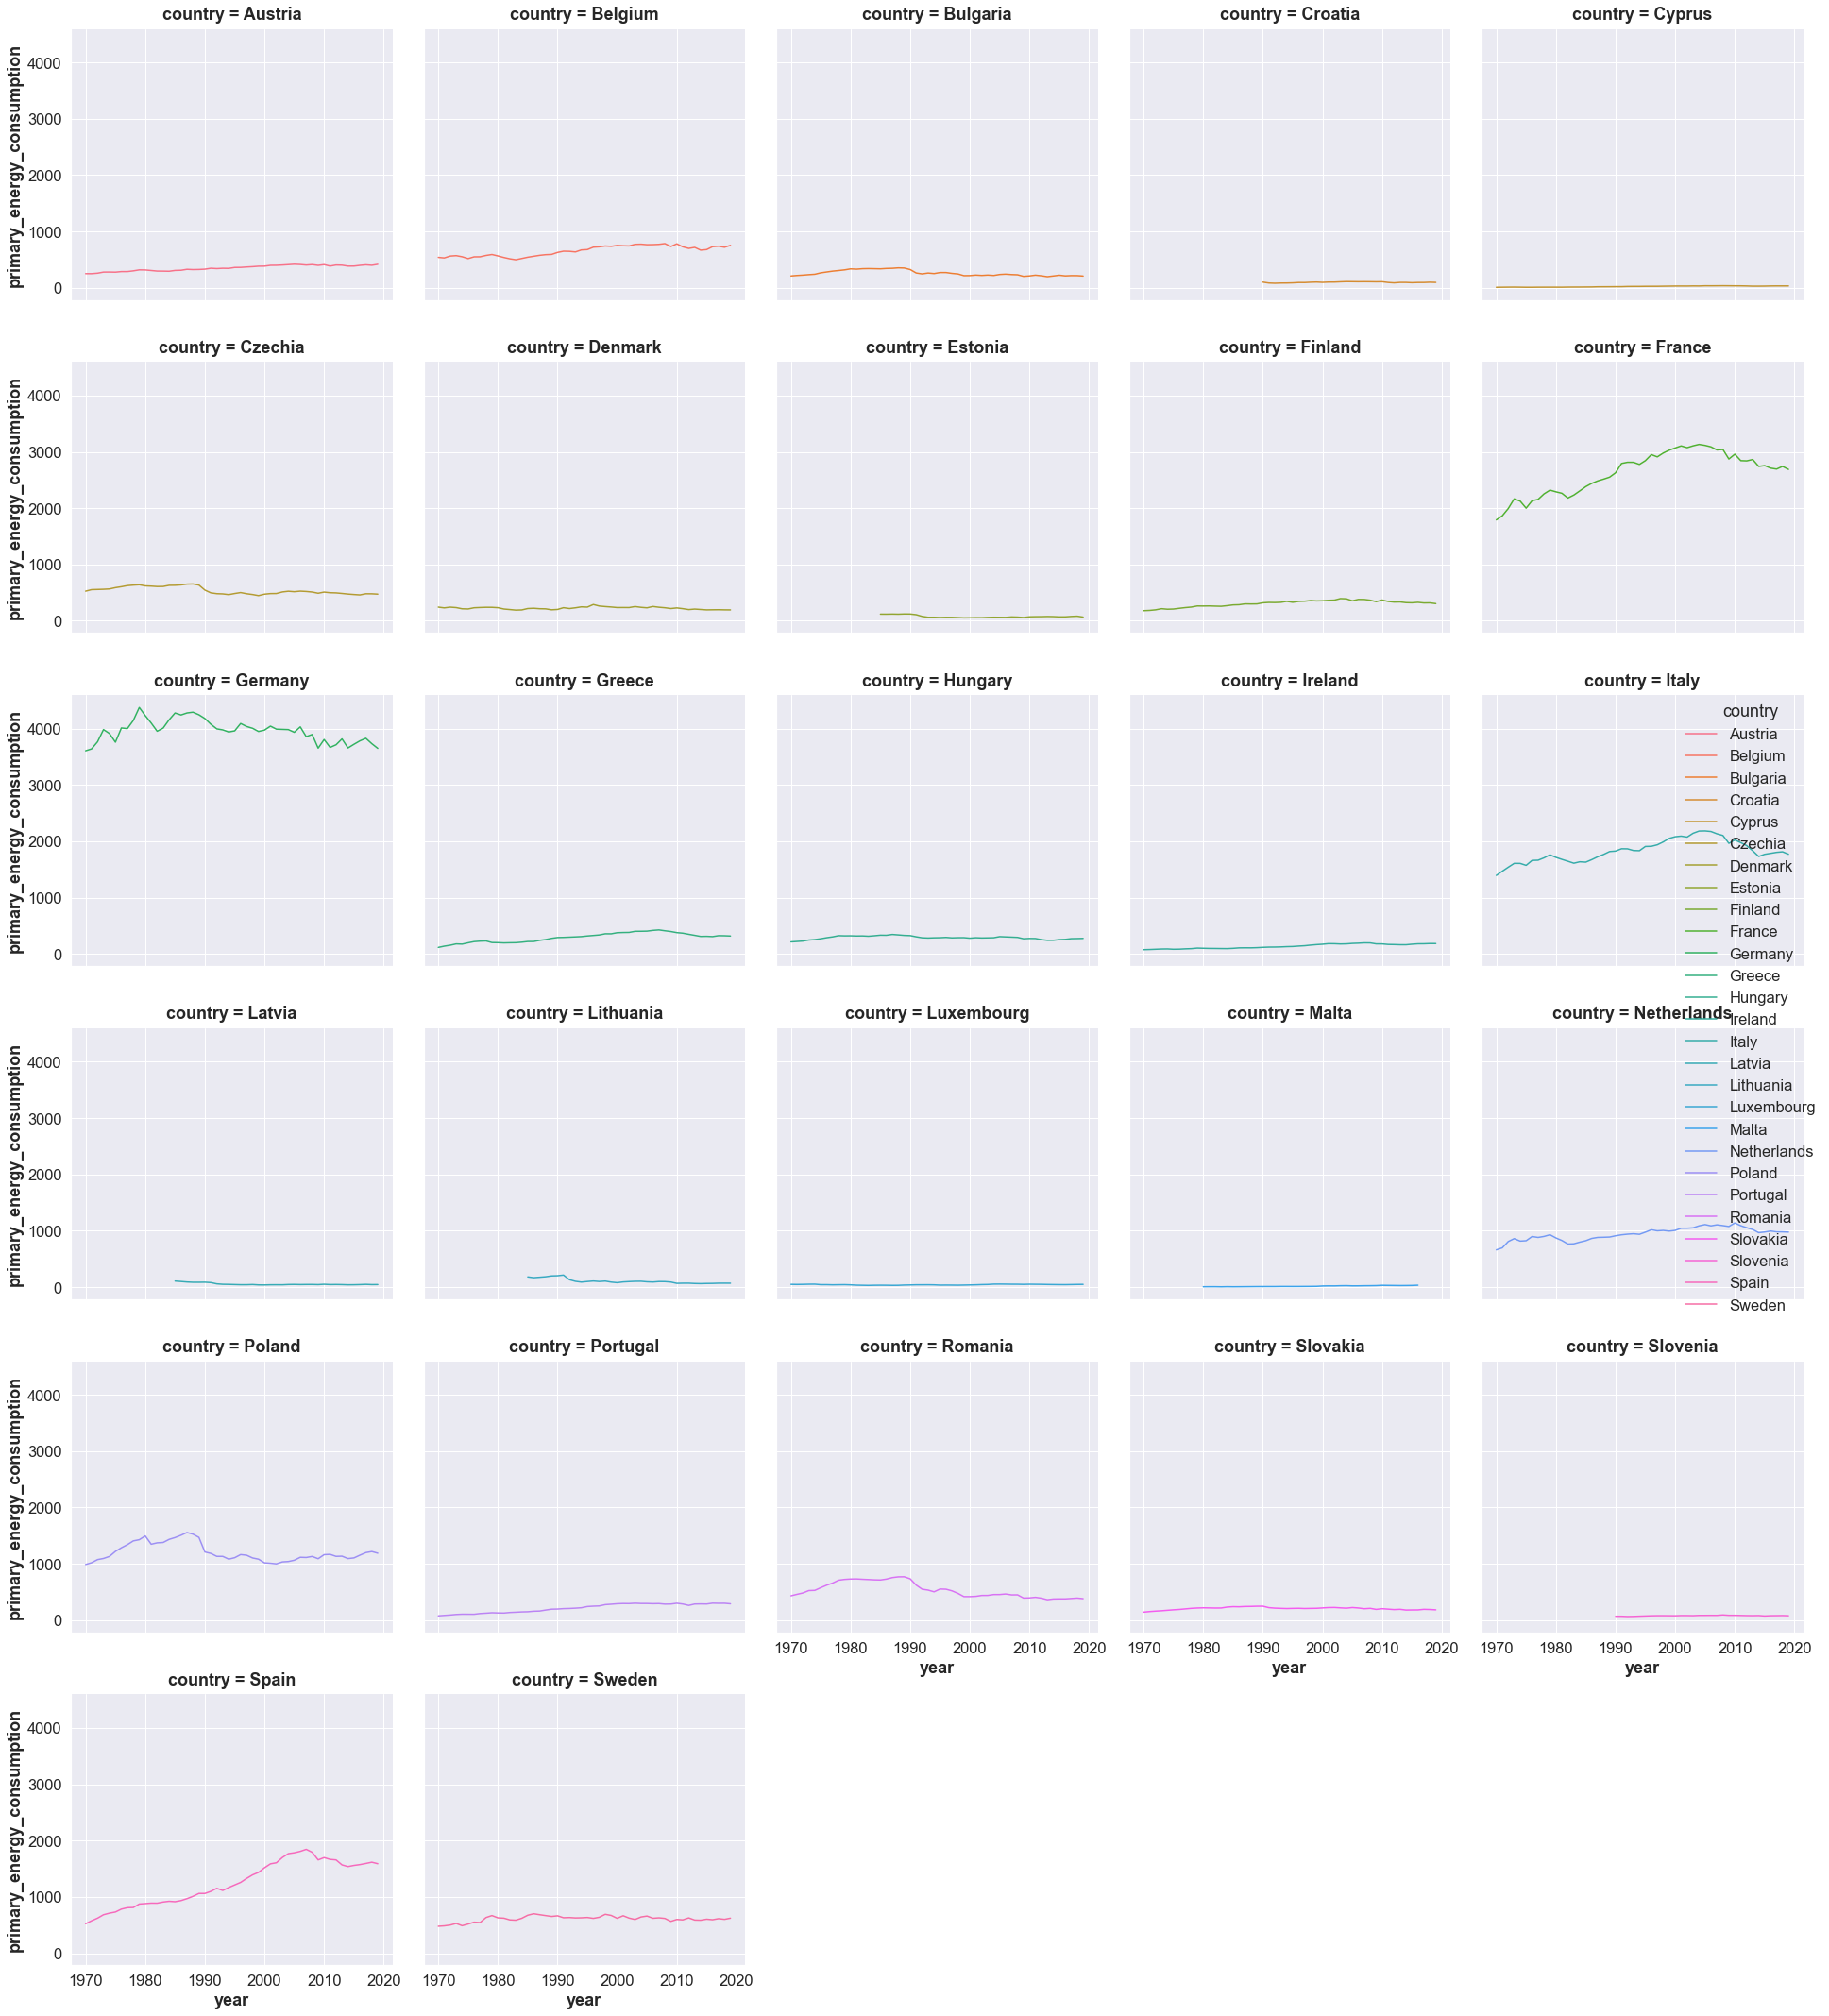

In [12]:
# To get a rough idea about the time series of each country, we develop the time plot the
# primary energy consumption and renewable electricity data

# Primary energy consumption

sns.set(font_scale=1.5)
sns.relplot(x='year', y='primary_energy_consumption', col='country', hue='country', kind="line", data=df_EU_short, col_wrap=5);

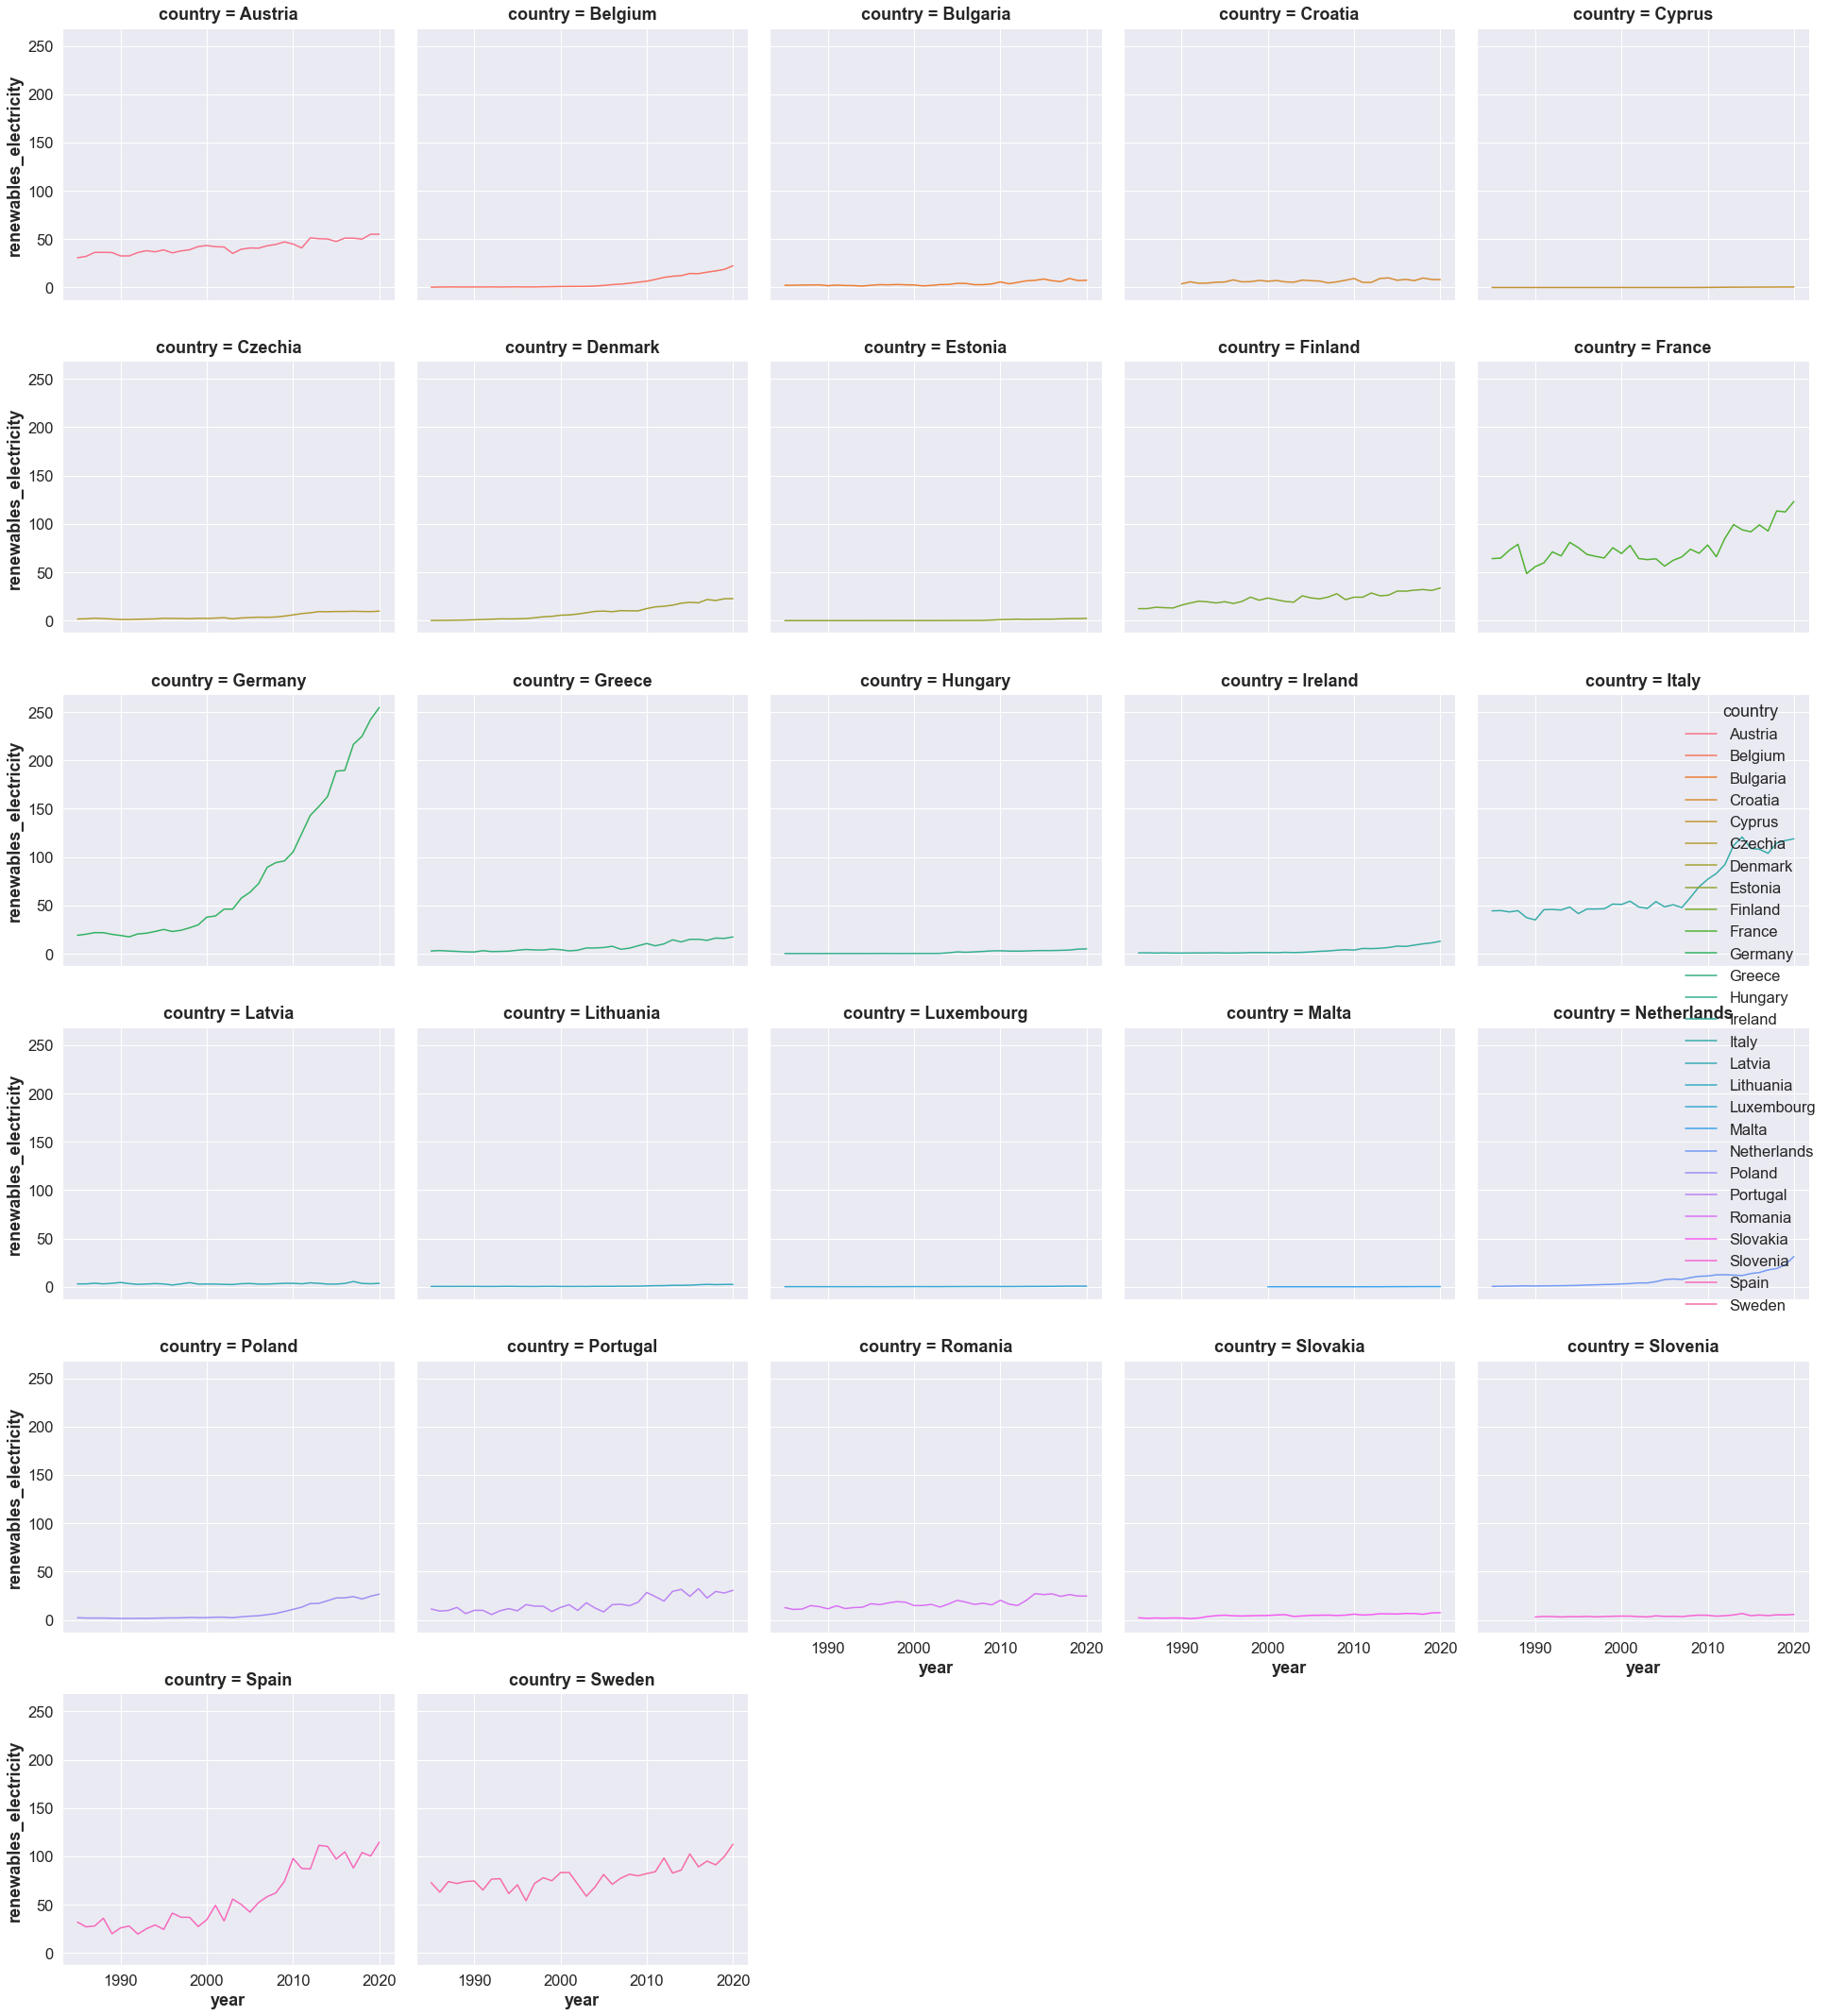

In [11]:
# Renewable electricity data for individual countires

sns.set(font_scale=1.5)
sns.relplot(x='year', y='renewables_electricity', col='country', hue='country', kind="line", data=df_EU_short, col_wrap=5);


<ipython-input-15-c434e7cc275a>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = pyplot.subplots()


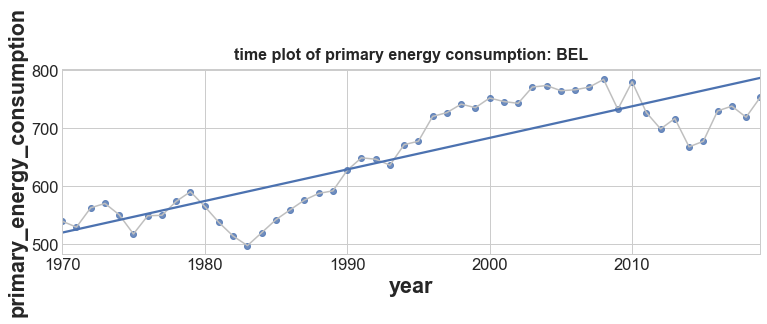

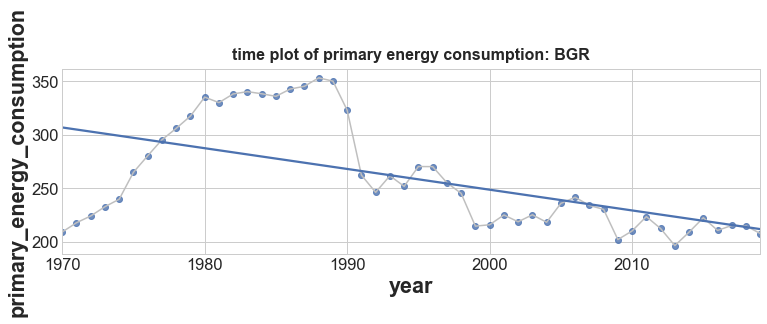

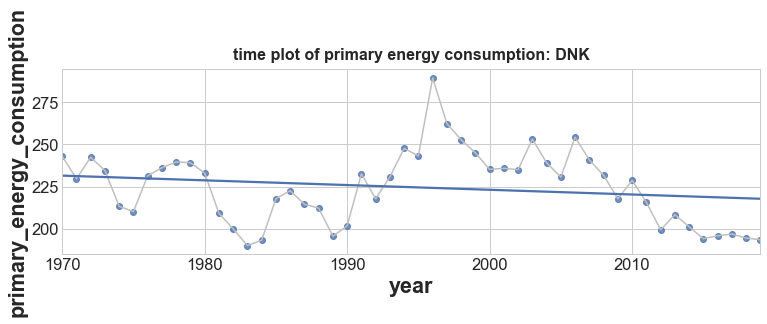

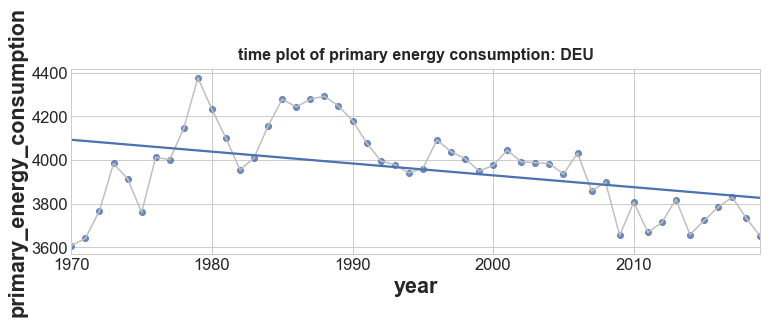

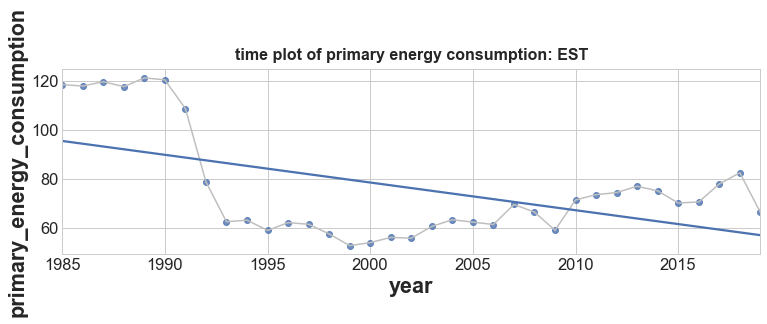

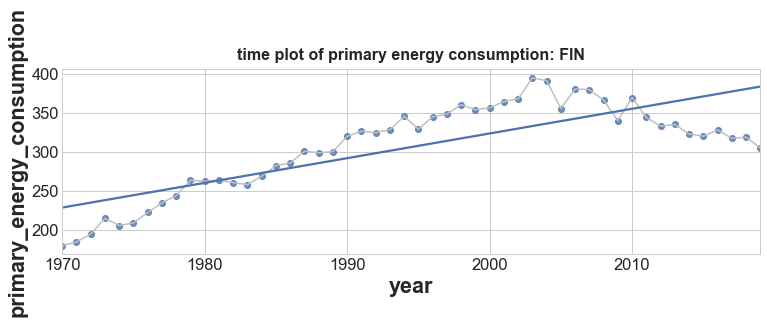

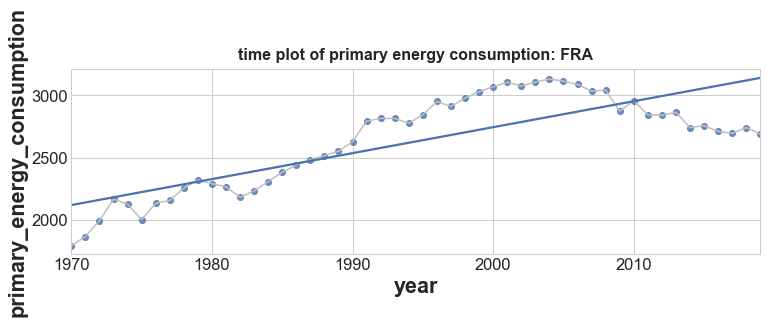

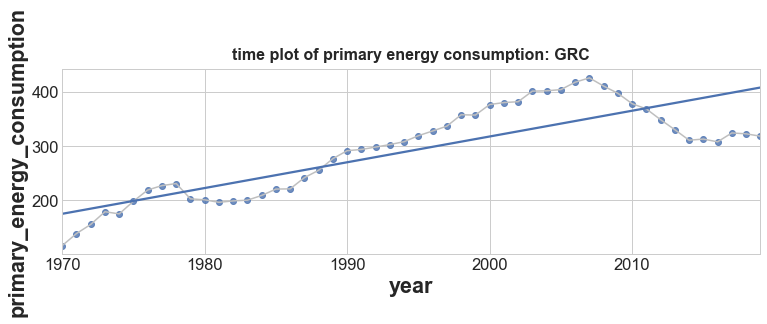

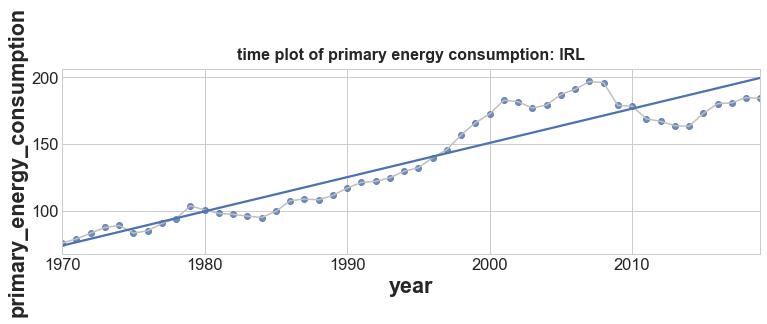

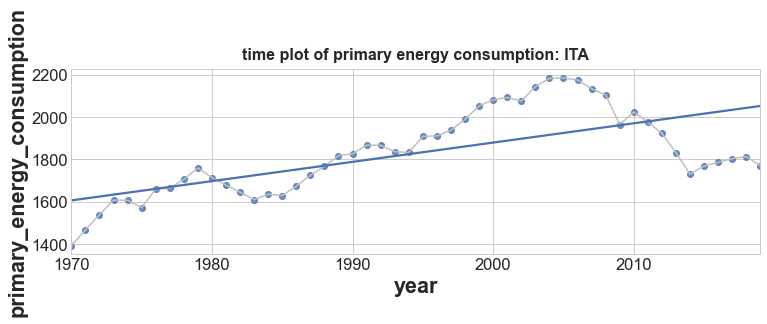

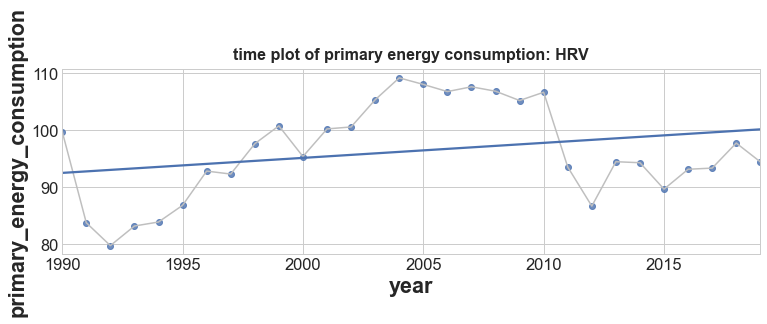

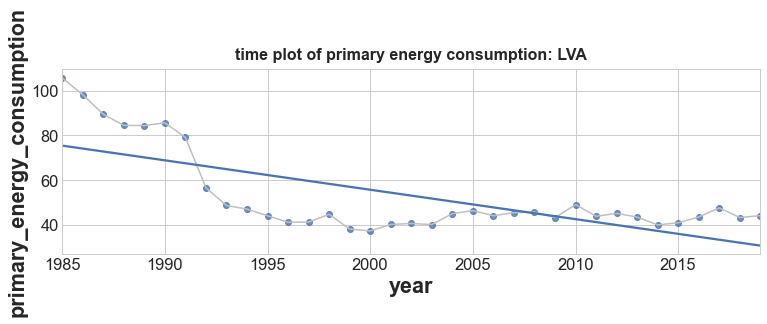

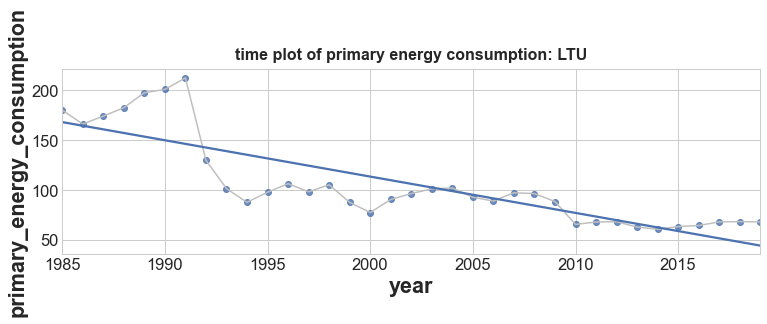

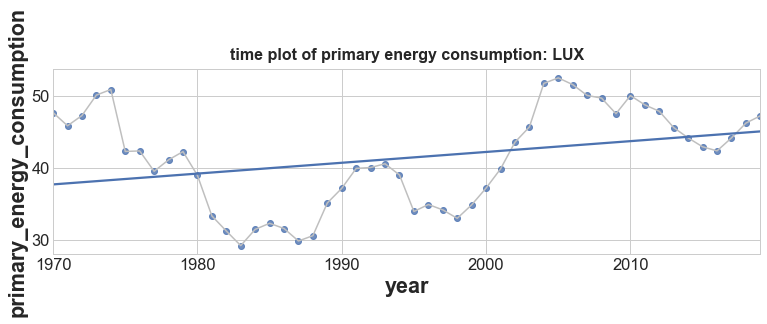

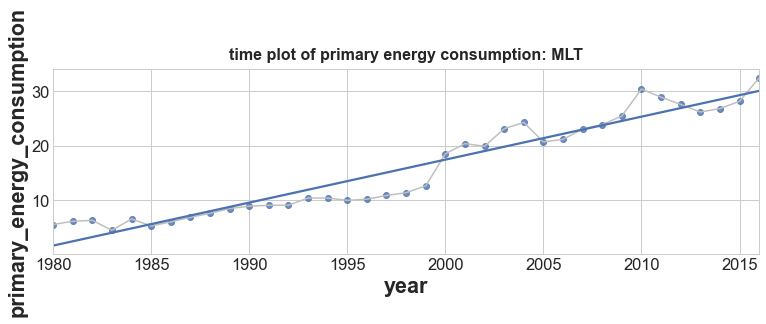

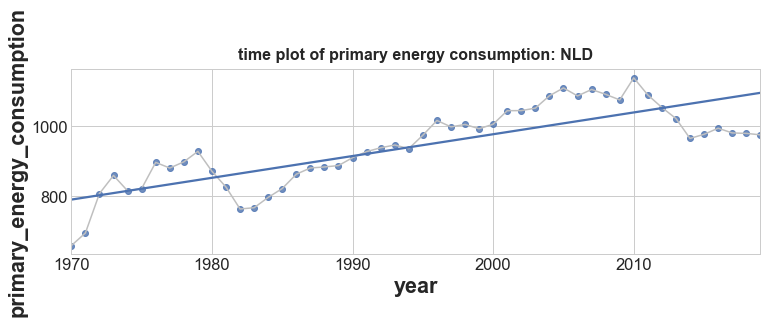

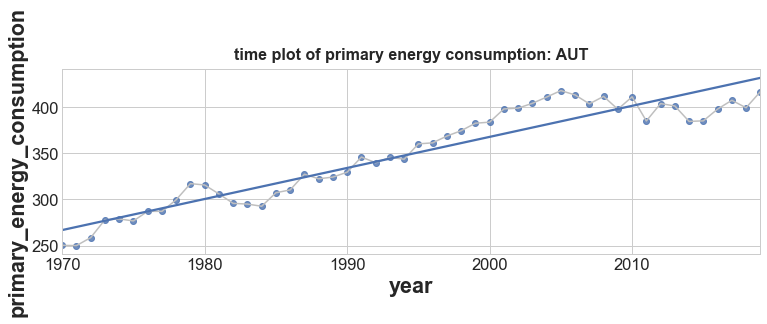

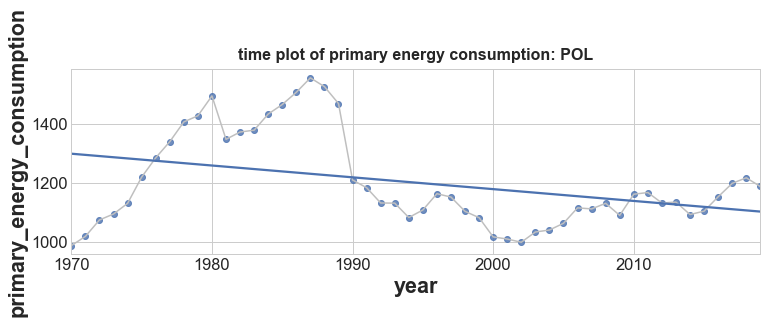

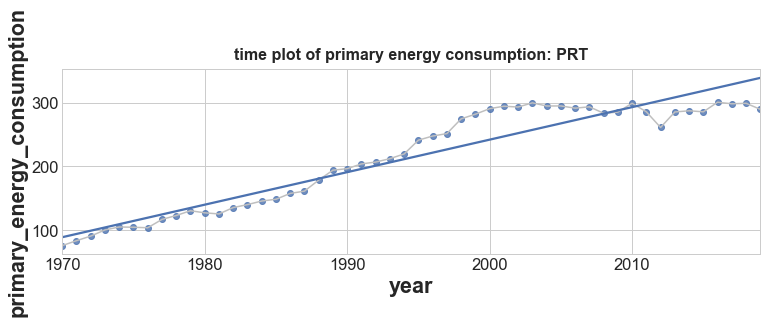

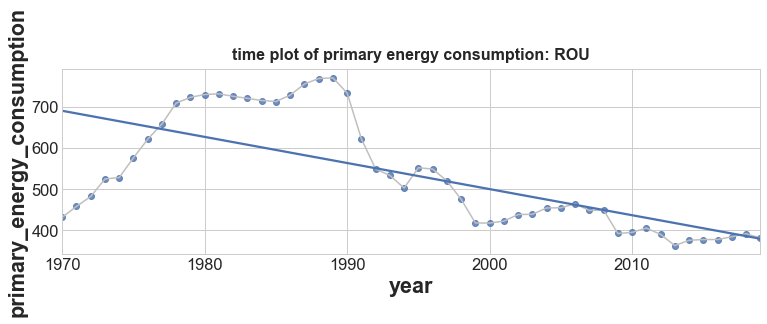

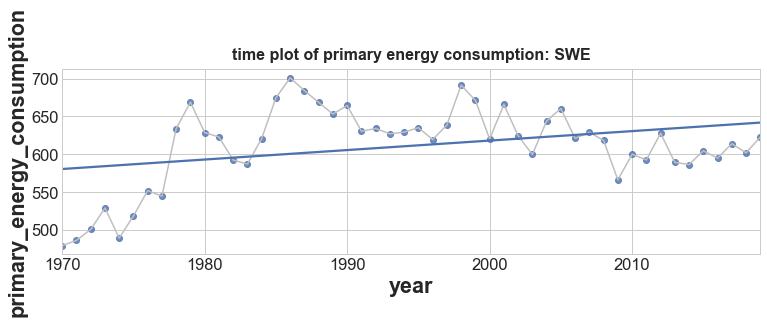

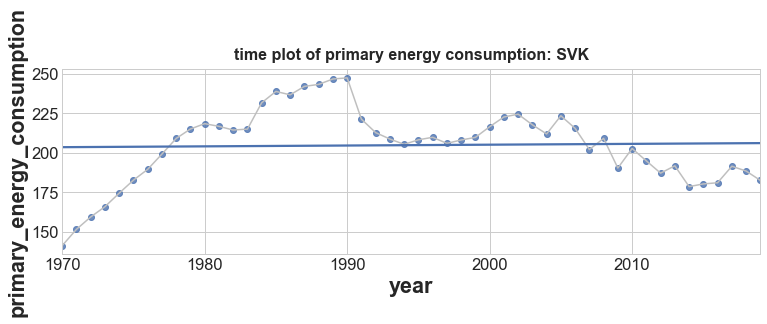

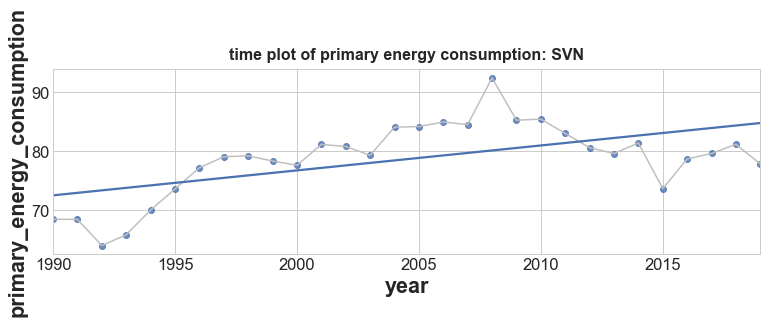

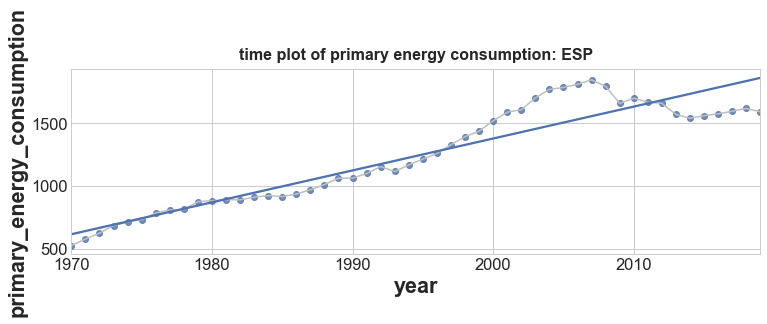

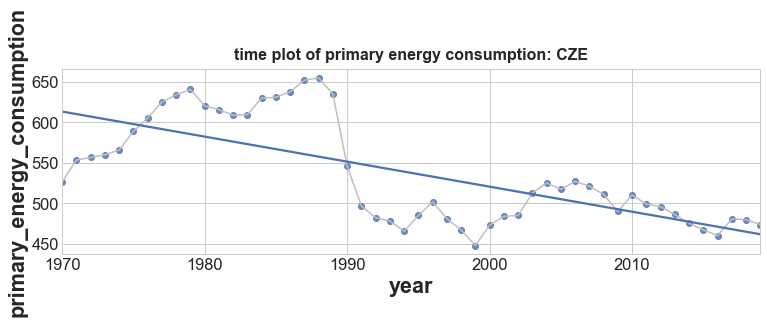

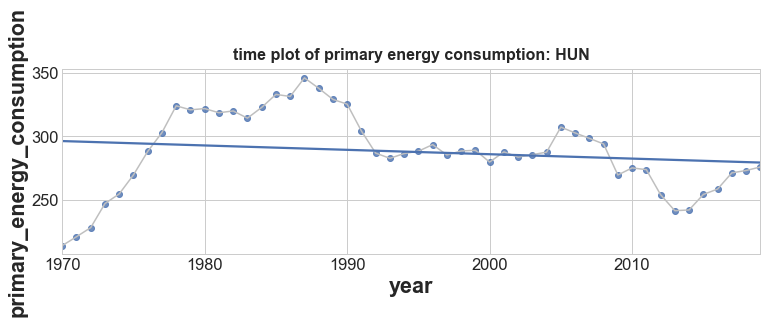

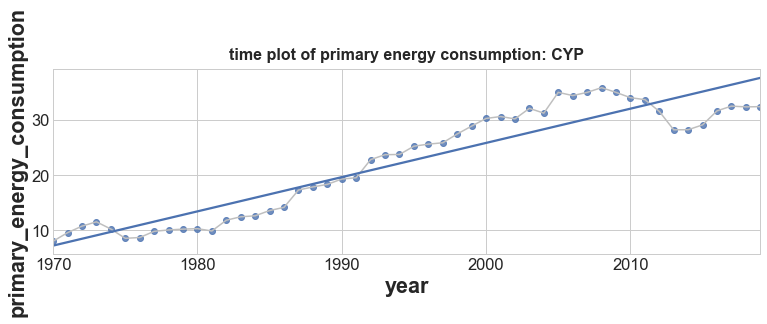

In [15]:
# Detailed time plots were also made for primry energy consumption of individual countries:

pyplot.style.use("seaborn-whitegrid")
pyplot.rc("figure", autolayout = True, figsize = (11,4), titlesize = 18, titleweight = "bold")
pyplot.rc("axes", labelweight = "bold", labelsize = "large", titleweight = "bold", titlesize = 16, titlepad = 10)

%config InlineBacken.figure_format = "retine"

for country in EU_countrylist:
    fig, ax = pyplot.subplots()
    ax.plot("year", "primary_energy_consumption", data = df_EU_short[df_EU_short.iso_code == country], color = "0.75")
    ax = sns.regplot(x = "year", y = "primary_energy_consumption", data = df_EU_short[df_EU_short.iso_code == country], ci = None)
    ax.set_title("time plot of primary energy consumption: "+country)

<ipython-input-18-db4939bf70c1>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = pyplot.subplots()


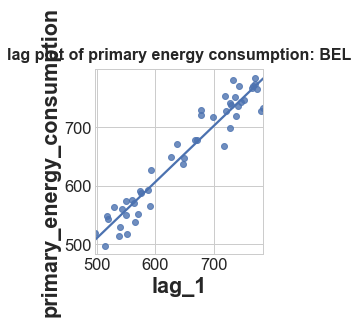

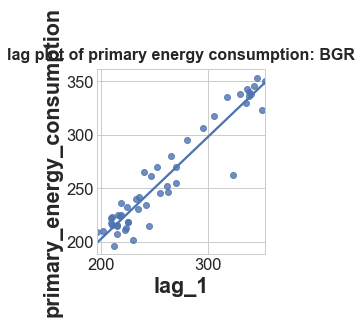

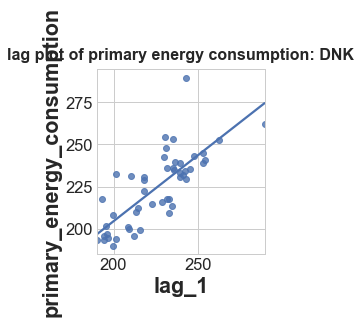

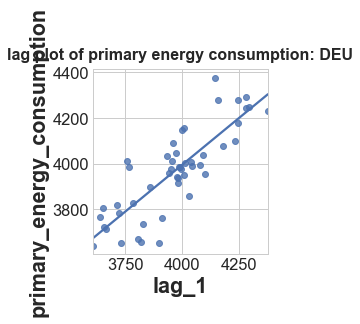

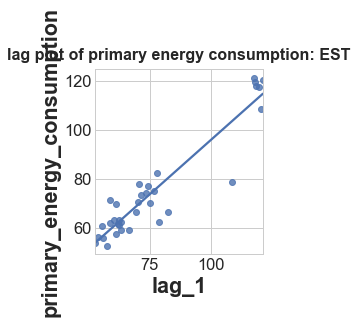

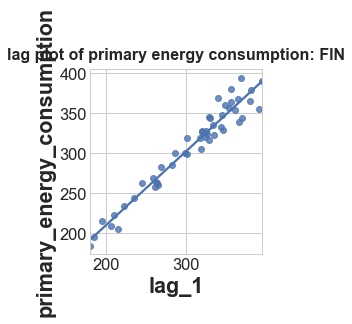

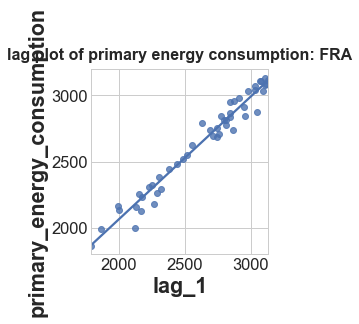

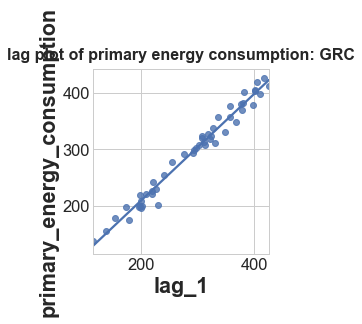

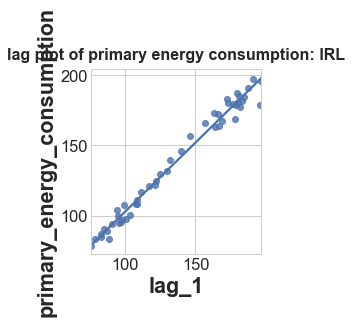

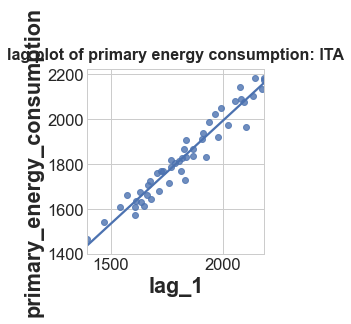

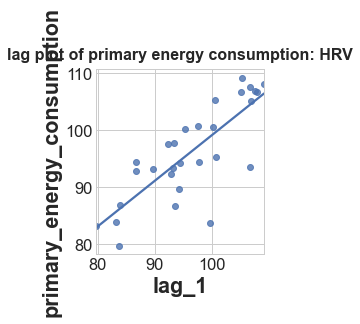

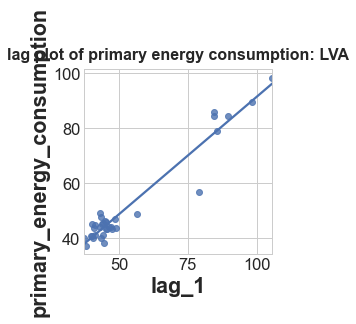

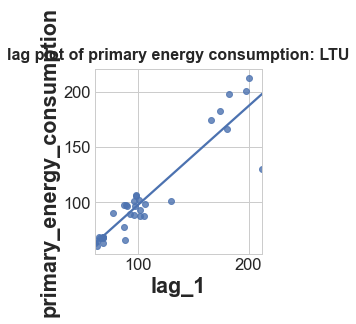

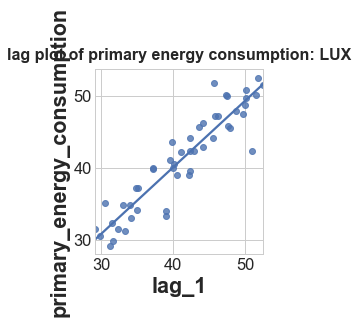

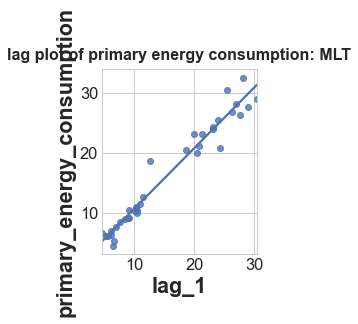

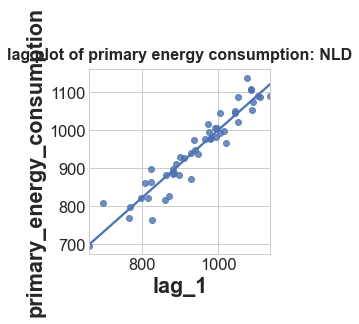

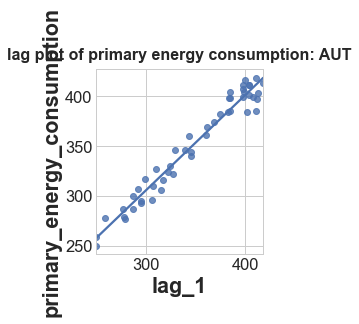

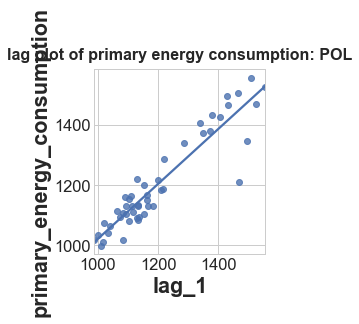

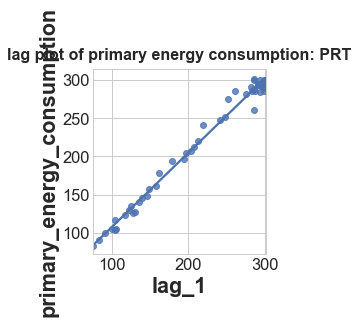

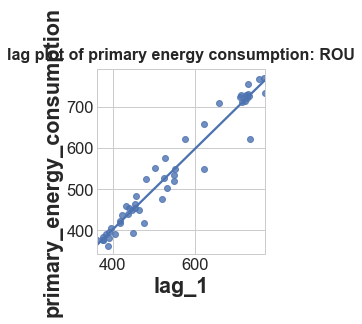

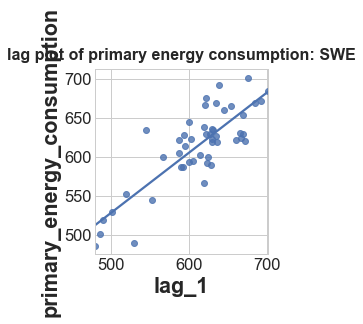

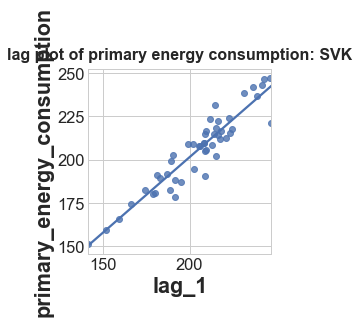

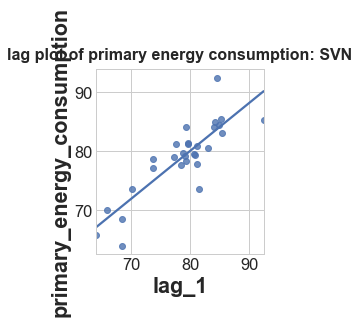

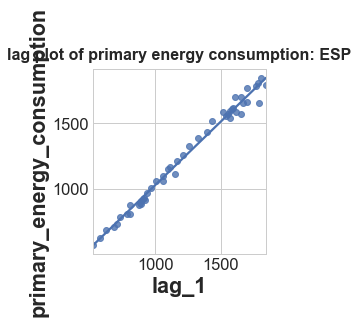

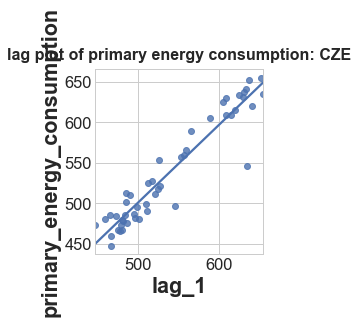

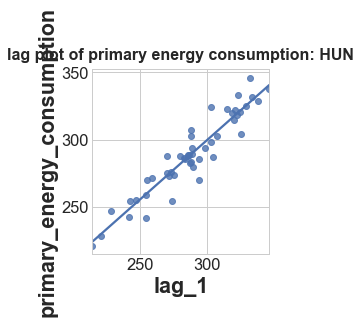

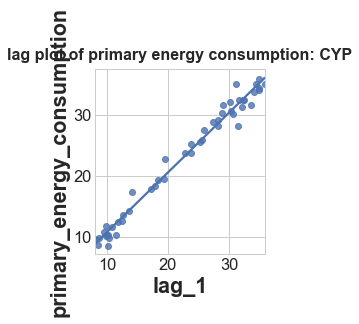

In [18]:
# Lag plots for primary energy consumption was also made for lag = 1 
df_EU_short["lag_1"] = df_EU_short.primary_energy_consumption.shift(1)
df_pec = df_EU_short.reindex(columns = ['iso_code','primary_energy_consumption','lag_1','year'])

for country in EU_countrylist:
    fig, ax = pyplot.subplots()
    ax = sns.regplot(x = "lag_1", y = "primary_energy_consumption", data = df_pec[df_pec.iso_code == country], ci = None)
    ax.set_aspect('equal')
    ax.set_title("lag plot of primary energy consumption: "+country)

Text(0.5, 1.0, 'time plot of primary energy consumption for EU')

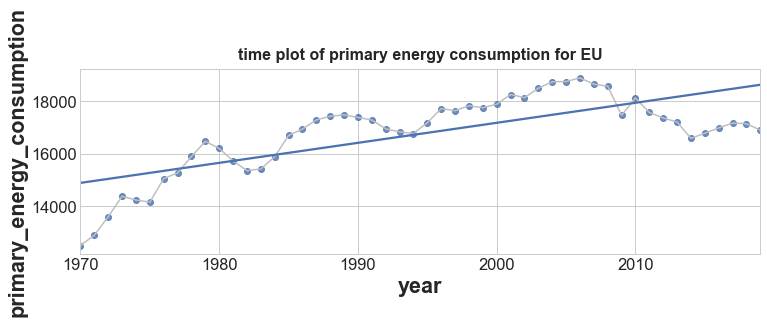

In [35]:
# Time series plot for total primary energy consumption of EU was also developed:

# Total primary energy consumption for EU from 1970 to 2019
df_EU_pec = df_EU_short.groupby("year").sum()
df_EU_pec[['primary_energy_consumption']]
df_EU_pec = df_EU_pec.drop(df_EU_pec[df_EU_pec.index == 2020].index)
df_EU_pec.reset_index(inplace = True)

# Plotting time series for EU's primary energy consumtion
fig, ax = pyplot.subplots()
ax.plot("year", "primary_energy_consumption", data = df_EU_pec, color = "0.75")
ax = sns.regplot(x = 'year', y = "primary_energy_consumption", data = df_EU_pec, ci = None)
ax.set_title("time plot of primary energy consumption for EU")


## Autoregression model for EU (total of all countries)
Autoregression models are developed for both primary energy consumption and renewable electricity data

### For primary Energy consumption

In [95]:
# For primary energy consumption data:
df_EU_cons = df_EU.copy()
df_EU_cons = pd.DataFrame(df_EU_pec.groupby("year", as_index = False).agg({"primary_energy_consumption": "sum"}))
# Data is better available from 1980, therefore, only this period is considered
df_EU_cons = df_EU_cons[df_EU_cons.year > 1980]
df_EU_cons.drop(120, inplace = True)

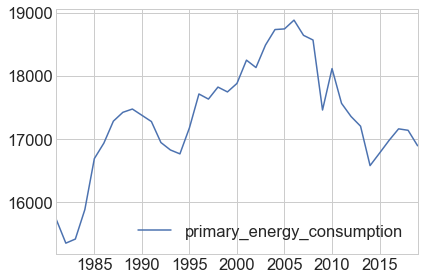

In [96]:
# Plotting time sereis again for total primary energy consimption for EU
df_EU_cons.index = pd.Index(sm.tsa.datetools.dates_from_range('1981', '2019'))
del df_EU_cons["year"]
df_EU_cons.plot()
pyplot.show()

### For renewable electricity

In [72]:
# For renewable electricity data
df_EU_prod = df_EU.copy()
df_EU_prod = pd.DataFrame(df_EU_prod.groupby("year", as_index = False).agg({"renewables_electricity": "sum"}))

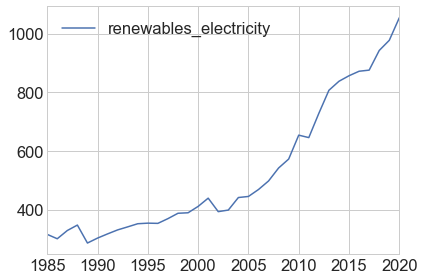

In [73]:
# Since renewable electricty data is better available from 1984, we will consider this period for the model
df_EU_prod = df_EU_prod[df_EU_prod.year > 1984]
df_EU_prod.head()
df_EU_prod.index = pd.Index(sm.tsa.datetools.dates_from_range('1985', '2020'))
del df_EU_prod["year"]
# Plotting the time series for total renewable electricity data for EU
df_EU_prod.plot()
pyplot.show()


### Quick check for autocorrelation
There is a quick, visual check that we can do to see if there is an autocorrelation in our time series dataset.

We can plot the observation at the previous time step (t-1) with the observation at the next time step (t+1) as a scatter plot.

This could be done manually by first creating a lag version of the time series dataset and using a built-in scatter plot function in the Pandas library.

But there is an easier way.

Pandas provides a built-in plot to do exactly this, called the lag_plot() function.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


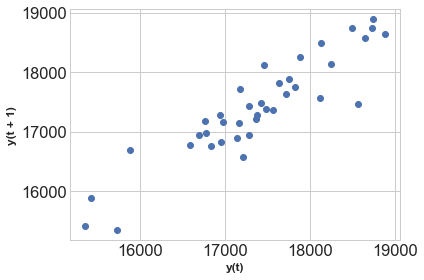

In [97]:
# lag_plot for EU's primary energy consumption
lag_plot(df_EU_cons)
pyplot.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


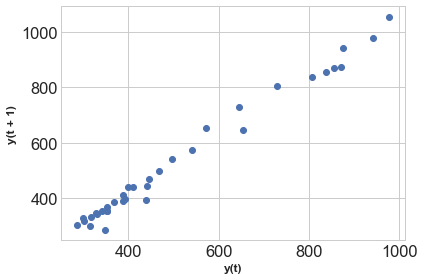

In [51]:
# lag_plot fpr EU's renewable electricity share
lag_plot(df_EU_prod)
pyplot.show()

## Autocorrelation Plots

We can plot the correlation coefficient for each lag variable.

This can very quickly give an idea of which lag variables may be good candidates for use in a predictive model and how the relationship between the observation and its historic values changes over time.

We could manually calculate the correlation values for each lag variable and plot the result. Thankfully, Pandas provides a built-in plot called the autocorrelation_plot() function.

The plot provides the lag number along the x-axis and the correlation coefficient value between -1 and 1 on the y-axis. The plot also includes solid and dashed lines that indicate the 95% and 99% confidence interval for the correlation values. Correlation values above these lines are more significant than those below the line, providing a threshold or cutoff for selecting more relevant lag values


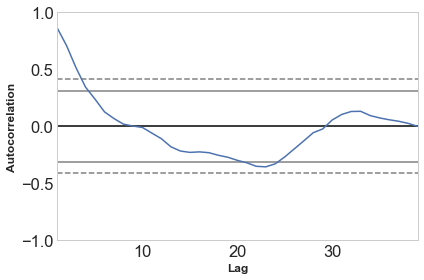

In [98]:
# Autocorrelation plot fpr primary energy consumption
autocorrelation_plot(df_EU_cons)
pyplot.show()

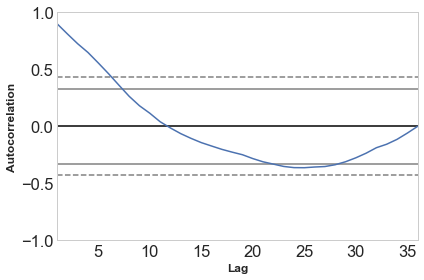

In [54]:
# Autocorrelation plot for renewable electricity data
autocorrelation_plot(df_EU_prod)
pyplot.show()

### ACF plot
The statsmodels library also provides a version of the plot in the plot_acf() function as a line plot

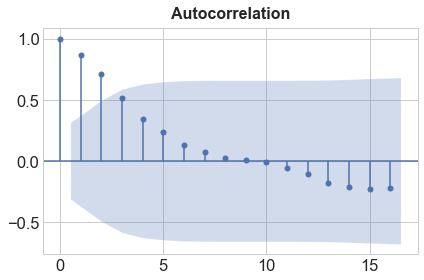

In [99]:
# ACF for primary energy consumption
plot_acf(df_EU_cons)
pyplot.show()

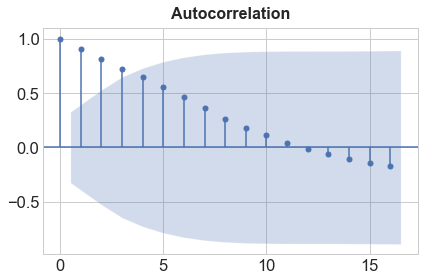

In [100]:
# ACF for renewable electricity
plot_acf(df_EU_prod)
pyplot.show()

Now that we know how to review the autocorrelation in our time series, let’s look at modeling it with an autoregression.

Before we do that, let’s establish a baseline performance.

## Persistance model
Running the example prints the mean squared error (MSE).

The value provides a baseline performance for the problem. The expected values for the next 5 years are plotted (blue) compared to the predictions from the model (red).

#### Persistance model for total primary energy consumption for EU

Test MSE: 34704.625


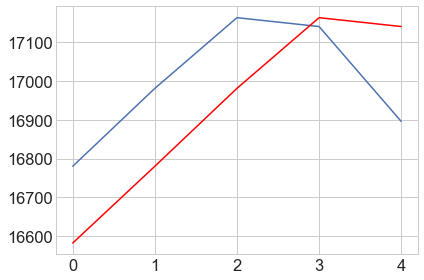

In [101]:
# create lagged dataset
values = pd.DataFrame(df_EU_cons.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-5], X[len(X)-5:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
 
# persistence model
def model_persistence(x):
	return x
 
# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

#### Persistance model for total renewable electricity share for EU

Test MSE: 2379.335


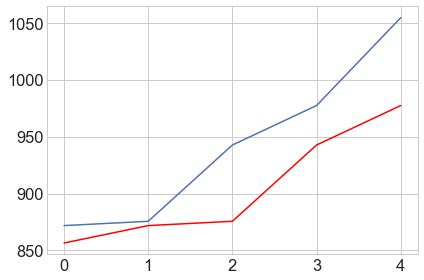

In [102]:
# create lagged dataset
values = pd.DataFrame(df_EU_prod.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-5], X[len(X)-5:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
 
# persistence model
def model_persistence(x):
	return x
 
# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

### Autoregression Model

An autoregression model is a linear regression model that uses lagged variables as input variables.

We could calculate the linear regression model manually using the LinearRegession class in scikit-learn and manually specify the lag input variables to use.

Alternately, the statsmodels library provides an autoregression model where you must specify an appropriate lag value and trains a linear regression model. It is provided in the AutoReg class.

We can use this model by first creating the model AutoReg() and then calling fit() to train it on our dataset. This returns an AutoRegResults object.

Once fit, we can use the model to make a prediction by calling the predict() function for a number of observations in the future. This creates 1 5-year forecast, which is different from the persistence example above.

The complete example is listed below.

Running the example the list of coefficients in the trained linear regression model.


#### Autoregression model for primary energy consumption

Coefficients: [3.03935412e+03 8.28462843e-01]
predicted=16776.853727, expected=16780.128000
predicted=16938.354047, expected=16981.241000
predicted=17072.151061, expected=17163.722000
predicted=17182.996916, expected=17140.856000
predicted=17274.828588, expected=16895.977000
Test RMSE: 176.374


/Users/fathimaabdulrahman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


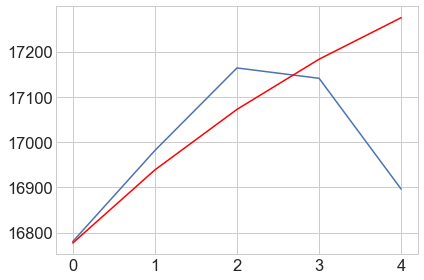

In [119]:
# split dataset
X = df_EU_cons.values
train, test = X[1:len(X)-5], X[len(X)-5:]
# train autoregression
model = AutoReg(train, lags = 1)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = math.sqrt(mean_squared_error(test_cons, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

#### Prediction for primary energy consumption in 2030

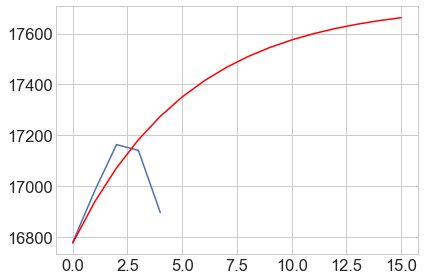

year = 2015, predicted = 908.912395
year = 2016, predicted = 965.599830
year = 2017, predicted = 1026.919191
year = 2018, predicted = 1093.248951
year = 2019, predicted = 1164.998509
year = 2020, predicted = 1242.610717
year = 2021, predicted = 1326.564612
year = 2022, predicted = 1417.378372
year = 2023, predicted = 1515.612516
year = 2024, predicted = 1621.873363
year = 2025, predicted = 1736.816774
year = 2026, predicted = 1861.152200
year = 2027, predicted = 1995.647063
year = 2028, predicted = 2141.131489
year = 2029, predicted = 2298.503434
year = 2030, predicted = 2468.734227


In [127]:
# Predictions for primary energy consumption 
predictions = model_fit.predict(start=len(train), end=len(train)+15, dynamic=False)
# plot results
pyplot.plot(test_cons)
pyplot.plot(predictions_cons, color='red')
pyplot.show()
for i in range(len(predictions)):
	print('year = %d, predicted = %f' % (2015 + i, predictions[i]))

#### Autoregression model for renewable electricity share

Coefficients: [-17.57971379   1.08170991]
predicted=908.912395, expected=871.830000
predicted=965.599830, expected=875.614000
predicted=1026.919191, expected=942.607000
predicted=1093.248951, expected=977.301000
predicted=1164.998509, expected=1054.475000
Test RMSE: 91.914


/Users/fathimaabdulrahman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


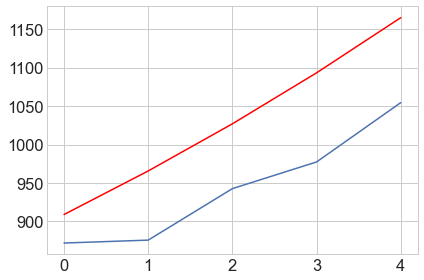

In [121]:
# split dataset
X = df_EU_prod.values
train, test = X[1:len(X)-5], X[len(X)-5:]
# train autoregression
model = AutoReg(train, lags = 1)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

#### Prediction for renenwable electricity in 2030

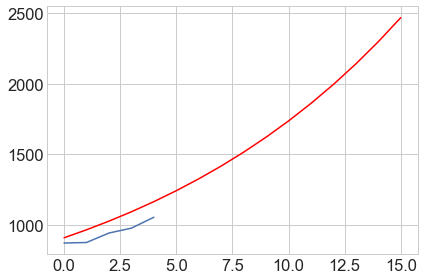

year = 2015, predicted = 908.912395
year = 2016, predicted = 965.599830
year = 2017, predicted = 1026.919191
year = 2018, predicted = 1093.248951
year = 2019, predicted = 1164.998509
year = 2020, predicted = 1242.610717
year = 2021, predicted = 1326.564612
year = 2022, predicted = 1417.378372
year = 2023, predicted = 1515.612516
year = 2024, predicted = 1621.873363
year = 2025, predicted = 1736.816774
year = 2026, predicted = 1861.152200
year = 2027, predicted = 1995.647063
year = 2028, predicted = 2141.131489
year = 2029, predicted = 2298.503434
year = 2030, predicted = 2468.734227


In [126]:
# Predictions for renewable electricity share
predictions = model_fit.predict(start=len(train), end=len(train)+15, dynamic=False)
# plot results
pyplot.plot(test)
pyplot.plot(predictions_prod, color='red')
pyplot.show()
for i in range(len(predictions)):
	print('year = %d, predicted = %f' % (2015 + i, predictions[i]))

# ARIMA Model for EU Total
https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

The statsmodels library provides the capability to fit an ARIMA model.

An ARIMA model can be created using the statsmodels library as follows:

Define the model by calling ARIMA() and passing in the p, d, and q parameters. The model is prepared on the training data by calling the fit() function. Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted. Let’s start off with something simple. We will fit an ARIMA model to the entire dataset and review the residual errors.

First, we fit an ARIMA(5,1,0) model. This sets the lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.


/Users/fathimaabdulrahman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  warnings.warn('No frequency information was'
/Users/fathimaabdulrahman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  warnings.warn('No frequency information was'
/Users/fathimaabdulrahman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  warnings.warn('No frequency information was'


                                   SARIMAX Results                                    
Dep. Variable:     primary_energy_consumption   No. Observations:                   39
Model:                         ARIMA(1, 0, 0)   Log Likelihood                -284.986
Date:                        Tue, 21 Dec 2021   AIC                            575.973
Time:                                12:10:30   BIC                            580.963
Sample:                            12-31-1981   HQIC                           577.763
                                 - 12-31-2019                                         
Covariance Type:                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.695e+04    534.127     31.733      0.000    1.59e+04     1.8e+04
ar.L1          0.9263      0.060     15.325      0.000       0.808 

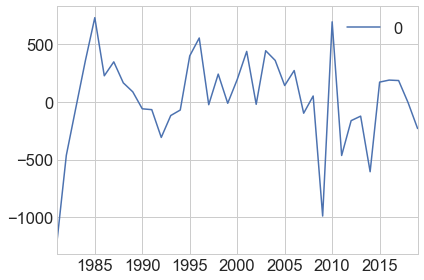

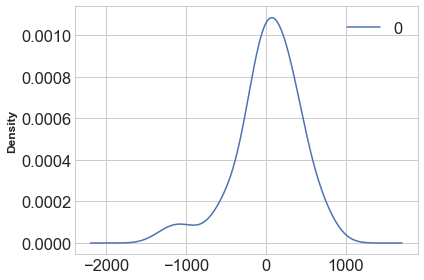

                 0
count    39.000000
mean     29.092908
std     399.953452
min   -1222.237781
25%    -108.137816
50%      50.880078
75%     255.929561
max     729.132941


In [130]:
# fit model for promary energy consumption
model_cons = ARIMA(df_EU_cons, order=(1,0,0))
model_fit = model_cons.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

/Users/fathimaabdulrahman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  warnings.warn('No frequency information was'
/Users/fathimaabdulrahman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  warnings.warn('No frequency information was'
/Users/fathimaabdulrahman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  warnings.warn('No frequency information was'


                                 SARIMAX Results                                  
Dep. Variable:     renewables_electricity   No. Observations:                   36
Model:                     ARIMA(5, 1, 0)   Log Likelihood                -168.998
Date:                    Tue, 21 Dec 2021   AIC                            349.996
Time:                            12:12:19   BIC                            359.328
Sample:                        12-31-1985   HQIC                           353.218
                             - 12-31-2020                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1000      0.204      0.491      0.624      -0.299       0.499
ar.L2          0.1738      0.150      1.161      0.246      -0.120       0.467
ar.L3          0.320

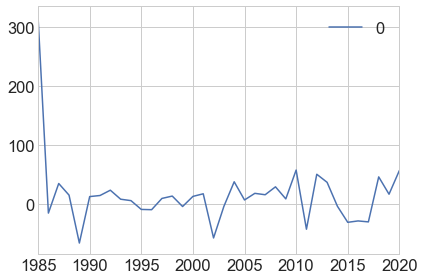

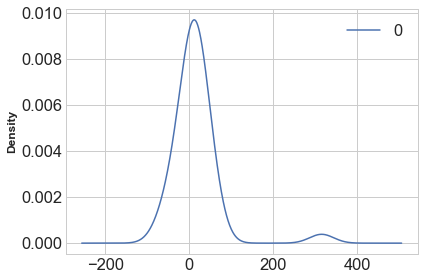

                0
count   36.000000
mean    15.763234
std     59.122675
min    -65.839307
25%     -5.253597
50%     12.938388
75%     25.018574
max    315.643000


In [132]:
# fit model for renewable electricity
model_prod = ARIMA(df_EU_prod, order=(5,1,0))
model_fit = model_prod.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

## Rolling Forecast ARIMA Model

The ARIMA model can be used to forecast future time steps.

We can use the predict() function on the ARIMAResults object to make predictions. It accepts the index of the time steps to make predictions as arguments. These indexes are relative to the start of the training dataset used to make predictions.

If we used 100 observations in the training dataset to fit the model, then the index of the next time step for making a prediction would be specified to the prediction function as start=101, end=101. This would return an array with one element containing the prediction.

We also would prefer the forecasted values to be in the original scale, in case we performed any differencing (d>0 when configuring the model). This can be specified by setting the typ argument to the value ‘levels’: typ=’levels’.

Alternately, we can avoid all of these specifications by using the forecast() function, which performs a one-step forecast using the model.

We can split the training dataset into train and test sets, use the train set to fit the model, and generate a prediction for each element on the test set.

A rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received.

We manually keep track of all observations in a list called history that is seeded with the training data and to which new observations are appended each iteration.

Putting this all together, below is an example of a rolling forecast with the ARIMA model in Python.


predicted=18768.915166, expected=18884.571000
predicted=18976.634741, expected=18643.820000
predicted=18689.263930, expected=18569.886000
predicted=18568.384682, expected=17461.989000
predicted=17446.557603, expected=18117.423000
predicted=17902.583133, expected=17567.267000
predicted=17576.566148, expected=17359.234000
predicted=17206.772284, expected=17205.596000
predicted=17260.062860, expected=16581.914000
predicted=16581.079979, expected=16780.128000
predicted=16566.850894, expected=16981.241000
predicted=16854.348966, expected=17163.722000
predicted=17117.990622, expected=17140.856000
predicted=17169.868997, expected=16895.977000
Test RMSE: 448.387


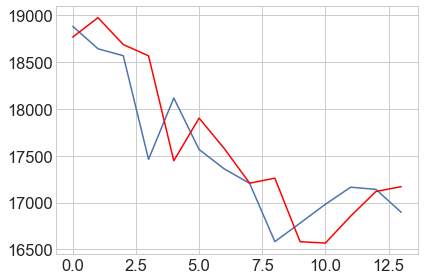

In [133]:
# Evaluate an ARIMA model for primary energy consumption using a walk-forward validation

# split into train and test sets
X = df_EU_cons.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

predicted=492.414717, expected=541.946000
predicted=554.182200, expected=572.386000
predicted=586.694769, expected=653.928000
predicted=694.073004, expected=645.579000
predicted=672.236748, expected=728.440000
predicted=760.790461, expected=806.918000
predicted=833.032426, expected=837.652000


/Users/fathimaabdulrahman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


predicted=885.664397, expected=856.507000
predicted=928.039067, expected=871.830000
predicted=910.462962, expected=875.614000
predicted=886.340865, expected=942.607000
predicted=957.516882, expected=977.301000
predicted=990.163797, expected=1054.475000
Test RMSE: 46.312


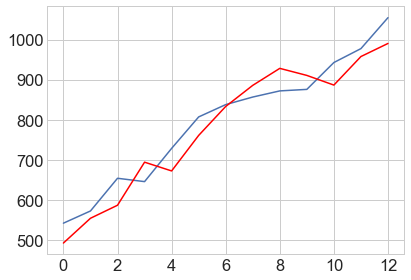

In [134]:
# Evaluate an ARIMA model for renewable electricity using a walk-forward validation

# split into train and test sets
X = df_EU_prod.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

## Grid Search ARIMA Model Hyperparameters

Evaluating a suite of parameters is relatively straightforward.

The user must specify a grid of p, d, and q ARIMA parameters to iterate. A model is created for each parameter and its performance evaluated by calling the evaluate_arima_model() function described in the previous section.

The function must keep track of the lowest error score observed and the configuration that caused it. This can be summarized at the end of the function with a print to standard out.

We can implement this function called evaluate_models() as a series of four loops.

There are two additional considerations. The first is to ensure the input data are floating point values (as opposed to integers or strings), as this can cause the ARIMA procedure to fail.

Second, the statsmodels ARIMA procedure internally uses numerical optimization procedures to find a set of coefficients for the model. These procedures can fail, which in turn can throw an exception. We must catch these exceptions and skip those configurations that cause a problem. This happens more often then you would think.


### Grid Search ARIMA Model - primary energy consumption

In [142]:
# grid search ARIMA parameters for primary energy consumption time series

from math import sqrt
from pandas import read_csv
import warnings
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = math.sqrt(mean_squared_error(test, predictions))
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
series = df_EU_cons
# evaluate parameters
p_values = [0, 1, 2, 4, 5, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=753.876
ARIMA(0, 0, 1) RMSE=638.927
ARIMA(0, 0, 2) RMSE=632.944
ARIMA(0, 1, 0) RMSE=436.859
ARIMA(0, 1, 1) RMSE=443.903
ARIMA(0, 1, 2) RMSE=430.849
ARIMA(0, 2, 0) RMSE=703.501
ARIMA(0, 2, 1) RMSE=536.251
ARIMA(0, 2, 2) RMSE=555.536
ARIMA(1, 0, 0) RMSE=424.529
ARIMA(1, 0, 1) RMSE=486.962
ARIMA(1, 0, 2) RMSE=460.692
ARIMA(1, 1, 0) RMSE=445.616
ARIMA(1, 1, 1) RMSE=474.066
ARIMA(1, 1, 2) RMSE=452.365
ARIMA(1, 2, 0) RMSE=565.029
ARIMA(1, 2, 1) RMSE=554.396
ARIMA(1, 2, 2) RMSE=558.693
ARIMA(2, 0, 0) RMSE=524.115
ARIMA(2, 0, 1) RMSE=528.202
ARIMA(2, 0, 2) RMSE=484.237
ARIMA(2, 1, 0) RMSE=433.270
ARIMA(2, 1, 1) RMSE=453.913
ARIMA(2, 2, 0) RMSE=558.080
ARIMA(2, 2, 1) RMSE=554.475
ARIMA(2, 2, 2) RMSE=555.967
ARIMA(4, 0, 0) RMSE=496.025
ARIMA(4, 0, 1) RMSE=521.552
ARIMA(4, 0, 2) RMSE=556.350
ARIMA(4, 1, 0) RMSE=446.487
ARIMA(4, 1, 1) RMSE=447.805
ARIMA(4, 2, 0) RMSE=550.077
ARIMA(4, 2, 1) RMSE=572.750
ARIMA(4, 2, 2) RMSE=567.965
ARIMA(5, 0, 0) RMSE=500.267
ARIMA(5, 0, 1) RMSE=

predicted=18704.497185, expected=18884.571000
predicted=18847.038167, expected=18643.820000
predicted=18609.368615, expected=18569.886000
predicted=18538.950263, expected=17461.989000
predicted=17433.777624, expected=18117.423000
predicted=18061.482448, expected=17567.267000
predicted=17533.289098, expected=17359.234000
predicted=17336.724325, expected=17205.596000
predicted=17191.514225, expected=16581.914000
predicted=16601.951913, expected=16780.128000
predicted=16789.972777, expected=16981.241000
predicted=16979.971360, expected=17163.722000
predicted=17151.920312, expected=17140.856000
predicted=17130.534363, expected=16895.977000
Test RMSE: 424.524


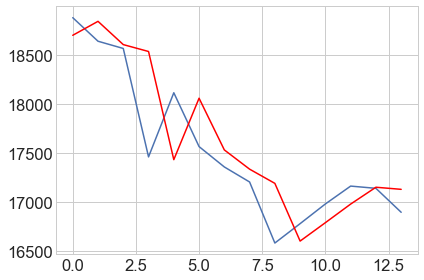

In [148]:
# split into train and test sets
X = df_EU_cons.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(1,0,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [149]:
# try to predict the production in 2030
X = df_EU_cons.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in X]
predictions = list()

model = ARIMA(history, order=(1,0,0))
model_fit = model.fit()
predictions = model_fit.predict(start=len(history), end=len(history)+10, dynamic=False)
print(predictions)

[16899.91396697 16903.56092584 16906.93923944 16910.06869693
 16912.96762976 16915.65301902 16918.14059494 16920.44492899
 16922.5795193  16924.55686967 16926.38856284]


### Grid Search ARIMA Model - renewable electricity

In [144]:
# grid search ARIMA parameters for renewable electricity time series
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = math.sqrt(mean_squared_error(test, predictions))
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
series = df_EU_prod
# evaluate parameters
p_values = [0, 1, 2, 4, 5, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=378.015
ARIMA(0, 0, 1) RMSE=218.581
ARIMA(0, 0, 2) RMSE=139.310
ARIMA(0, 1, 0) RMSE=52.495
ARIMA(0, 1, 1) RMSE=50.503
ARIMA(0, 1, 2) RMSE=52.836
ARIMA(0, 2, 0) RMSE=47.115
ARIMA(0, 2, 1) RMSE=37.908
ARIMA(0, 2, 2) RMSE=40.094
ARIMA(1, 0, 0) RMSE=55.241
ARIMA(1, 0, 1) RMSE=53.444
ARIMA(1, 0, 2) RMSE=55.740
ARIMA(1, 1, 0) RMSE=48.413
ARIMA(1, 1, 1) RMSE=41.956
ARIMA(1, 1, 2) RMSE=42.466
ARIMA(1, 2, 0) RMSE=39.083
ARIMA(1, 2, 1) RMSE=38.693
ARIMA(1, 2, 2) RMSE=41.543
ARIMA(2, 0, 0) RMSE=51.259
ARIMA(2, 0, 1) RMSE=51.845
ARIMA(2, 0, 2) RMSE=49.223
ARIMA(2, 1, 0) RMSE=48.492
ARIMA(2, 1, 1) RMSE=44.242
ARIMA(2, 1, 2) RMSE=43.748
ARIMA(2, 2, 0) RMSE=40.523
ARIMA(2, 2, 1) RMSE=41.939
ARIMA(2, 2, 2) RMSE=42.249
ARIMA(4, 0, 0) RMSE=48.151
ARIMA(4, 0, 1) RMSE=48.115
ARIMA(4, 0, 2) RMSE=55.770
ARIMA(4, 1, 0) RMSE=45.189
ARIMA(4, 1, 1) RMSE=47.075
ARIMA(4, 1, 2) RMSE=46.203
ARIMA(4, 2, 0) RMSE=43.346
ARIMA(4, 2, 1) RMSE=45.798
ARIMA(4, 2, 2) RMSE=46.850
ARIMA(5, 0, 0) RMSE=47.85

predicted=505.993447, expected=541.946000
predicted=556.088952, expected=572.386000
predicted=590.446690, expected=653.928000
predicted=691.044766, expected=645.579000
predicted=668.299955, expected=728.440000
predicted=764.755152, expected=806.918000
predicted=855.899269, expected=837.652000
predicted=881.084983, expected=856.507000
predicted=894.114319, expected=871.830000
predicted=905.015800, expected=875.614000
predicted=903.571309, expected=942.607000
predicted=977.248451, expected=977.301000
predicted=1011.934461, expected=1054.475000
Test RMSE: 37.908


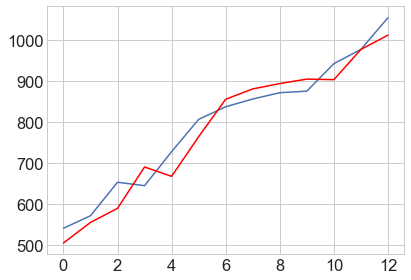

In [145]:
# split renewable energy data into train and test sets
X = df_EU_prod.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(0,2,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [146]:
# try to predict the renewable energy production in 2030
X = df_EU_prod.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in X]
predictions = list()

model = ARIMA(history, order=(0,2,1))
model_fit = model.fit()
predictions = model_fit.predict(start=len(history), end=len(history)+10, dynamic=False)
print(predictions)

[1096.95297812 1139.43095625 1181.90893437 1224.38691249 1266.86489061
 1309.34286874 1351.82084686 1394.29882498 1436.7768031  1479.25478123
 1521.73275935]
